### Current forecasting error and aggregated forecast

In [1]:
import pandas as pd



df = pd.read_csv('mv_port_processed.csv')

df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df['Project Number'] = df['Project Number'].astype('str') 
df = df.loc[:, ~df.columns.str.contains('^index')]


df_sub = df[['Date','Project Number','Actual Net Revenue - MTD','Project Status', 'Contract Type Name', 'Ultimate Customer AUS Market Sector', 'Division Short Name', 'Proj_CVP', 'Proj_Serv_Offering',
             'primary_client_industry', 'Funding Amount - ITC (Snapshot)', 'Backlog NR',  'Actual Direct Labor Cost - MTD', 'Actual Non-Labor Cost - MTD',
       'Actual Gross Revenue - MTD', 'EBITA - MTD',
       'Forecast Direct Labor Cost - ITC', 'Forecast Net Revenue - ITC',
       'Order Intake (NR) - MTD', 'AUS Mkt Sector Aggregate', 'Baseline NR', 'Organization Size',
       'Risk Profile', 'riskrating_project', 'ActualNR_sum', 'Projectduration', 'Completion', 'scheduled_duration', 'Scheduled_projectduration', 'intime', 'seasonality_month']]

/Users/julia/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3170: DtypeWarning: Columns (2,3,4,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,40,41,45,48,51,53,55,58) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [31]:
df_sub['Date'] = pd.to_datetime(df_sub['Date'], format='%Y%m') 

/Users/julia/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


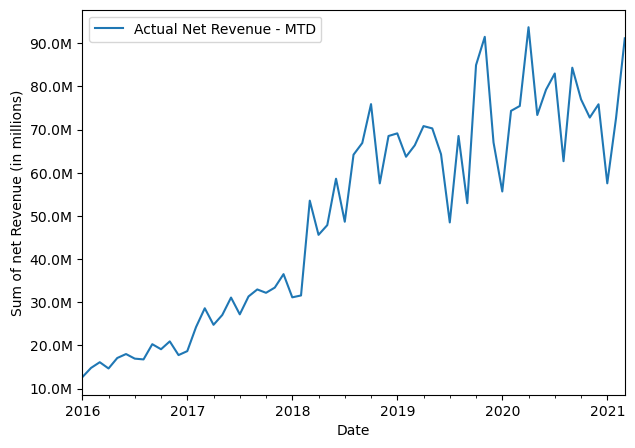

In [138]:
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter

def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x * 1e-6)


millions_formatter = FuncFormatter(millions)

sub=df_sub.groupby(['Date'])['Actual Net Revenue - MTD'].sum().reset_index()

sub.plot(x='Date', y='Actual Net Revenue - MTD', kind='line', figsize=(7,5))
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.gca().set_ylabel('Sum of net Revenue (in millions)')
plt.show()

In [125]:
df_sub['Actual Net Revenue - MTD'].describe()

count    1.269171e+06
mean     2.482369e+03
std      3.037958e+05
min     -5.056956e+07
25%      0.000000e+00
50%      0.000000e+00
75%      2.212300e+02
max      5.056956e+07
Name: Actual Net Revenue - MTD, dtype: float64

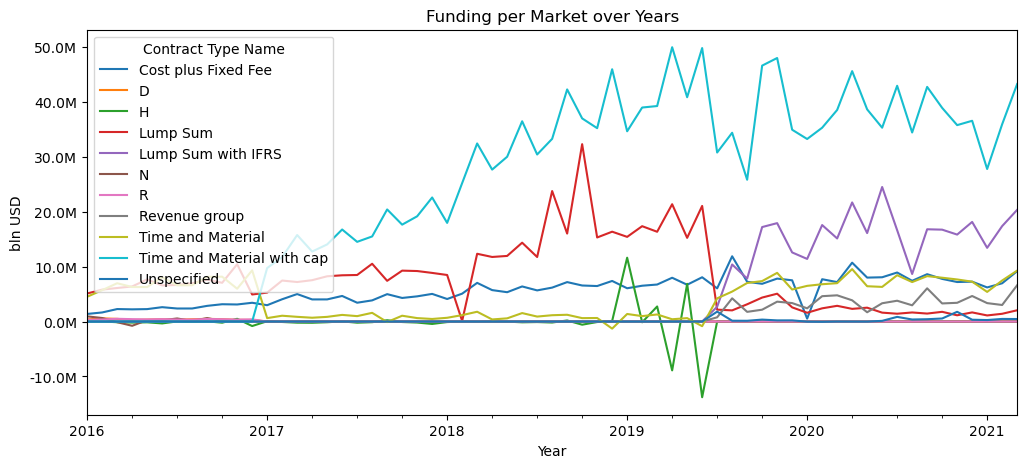

In [133]:
contracttypes = pd.pivot_table(df_sub,\
               values='Actual Net Revenue - MTD', index='Date', \
              columns='Contract Type Name', aggfunc='sum').fillna(0)

contracttypes.plot(figsize=(12,5));
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.xlabel('Date')
plt.ylabel('Sum of net Revenue (in millions)')
plt.title('Aggregated revenue per contract type');
plt.show()

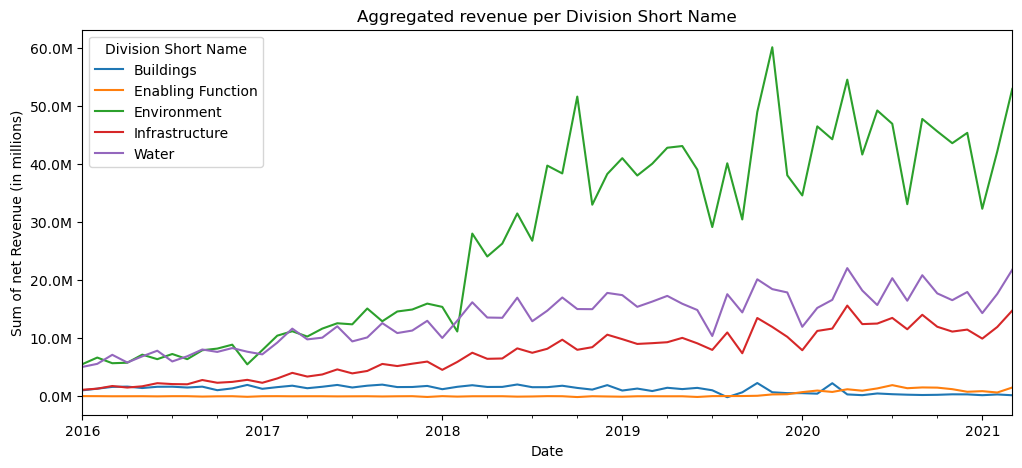

In [150]:
div = pd.pivot_table(df_sub,\
               values='Actual Net Revenue - MTD', index='Date', \
              columns='Division Short Name', aggfunc='sum').fillna(0)

div.plot(figsize=(12,5));
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.xlabel('Date')
plt.ylabel('Sum of net Revenue (in millions)')
plt.title('Aggregated revenue per Division Short Name');
plt.show()

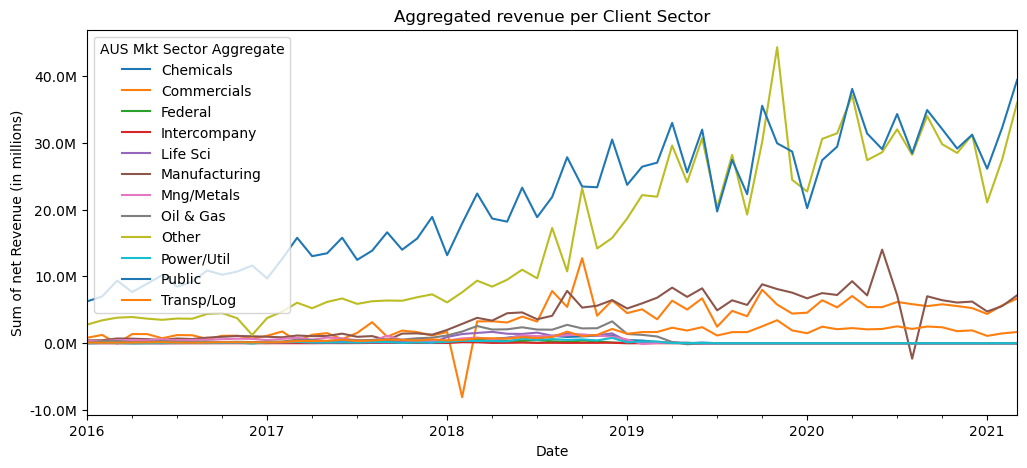

In [159]:
div = pd.pivot_table(df_sub,\
               values='Actual Net Revenue - MTD', index='Date', \
              columns='AUS Mkt Sector Aggregate', aggfunc='sum').fillna(0)

div.plot(figsize=(12,5));
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.xlabel('Date')
plt.ylabel('Sum of net Revenue (in millions)')
plt.title('Aggregated revenue per Client Sector');
plt.show()


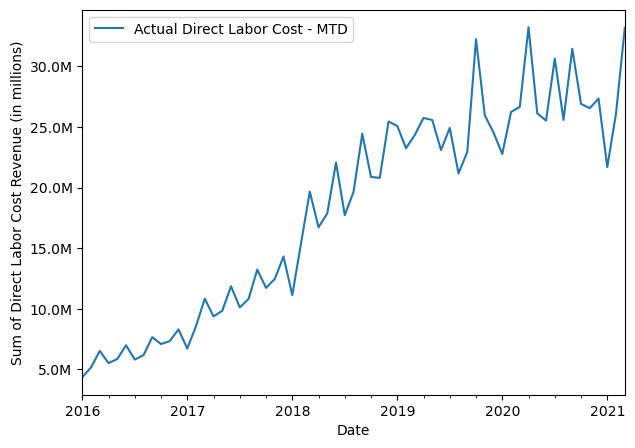

In [164]:
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter

def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x * 1e-6)


millions_formatter = FuncFormatter(millions)

sub=df_sub.groupby(['Date'])['Actual Direct Labor Cost - MTD'].sum().reset_index()

sub.plot(x='Date', y='Actual Direct Labor Cost - MTD', kind='line', figsize=(7,5))
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.gca().set_ylabel('Sum of Direct Labor Cost Revenue (in millions)')
plt.show()

In [ ]:
primary_client_industry

## We can also difference the time serie

### Augmented Dickey-Fuller test (ADF)
ADF tests the null hypothesis that a unit root is present in time series sample. ADF statistic is a negative number and more negative it is the stronger the rejection of the hypothesis that there is a unit root.
- Null Hypotehsis (H0): If accepted, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
- Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary.
- p-value > 0.05: Accept H0, the data has a unit root and is non-stationary
- p-value ≤ 0.05: Reject H0. the data does not have a unit root and is stationary

In [44]:
from statsmodels.tsa.stattools import adfuller

X = sub['Actual Net Revenue - MTD'].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.048906
p-value: 0.735012
Critical Values:
	1%: -3.548
	5%: -2.913
	10%: -2.594


### Clearly the series is non stationary, so we can try a common trick which is differencing

In [48]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

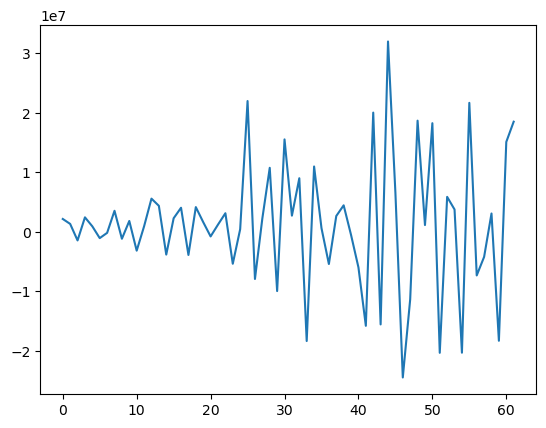

In [50]:
X = sub['Actual Net Revenue - MTD'].values
diff = difference(X)
plt.plot(diff)
plt.show()

In [54]:
''' The differenced time series seems to follow the ADF test'''
## Let's try the test again
X = diff
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -7.069342
p-value: 0.000000
Critical Values:
	1%: -3.548
	5%: -2.913
	10%: -2.594


### Let's check the mean forecasting error for 2020

In [118]:
errordf =df_sub[df_sub['Date'] > '2019-12-01']

In [146]:
errordf = errordf[errordf['Funding Amount - ITC (Snapshot)'].notna()]
errordf = errordf[errordf['Scheduled_projectduration'].notna()]
errordf = errordf[errordf['Forecast Net Revenue - ITC'].notna()]

In [120]:
errordf['Artifical Forecast'] = errordf['Funding Amount - ITC (Snapshot)'].divide( errordf['Scheduled_projectduration']) 

In [121]:
import numpy as np
from numpy import inf


errordf = errordf[errordf['Artifical Forecast'].notna()]

errordf = errordf[errordf['Actual Net Revenue - MTD'].notna()]



errordf[errordf['Artifical Forecast']== -inf] = 0

errordf[errordf['Artifical Forecast']== inf] = 0

In [147]:
''' Lets compute the current forecasting error'''

mse = ((errordf['Forecast Net Revenue - ITC'].values - errordf['Actual Net Revenue - MTD'].values) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 365013366701.59


In [143]:
''' Lets compute the current forecasting error'''

mse = ((errordf['Artifical Forecast'].values - errordf['Actual Net Revenue - MTD'].values) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 4878287784.81


In [144]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 69844.74


In [124]:
errordf['Actual Net Revenue - MTD'].describe()

count    6.680090e+05
mean     1.682273e+03
std      2.333282e+04
min     -6.284046e+06
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      8.126423e+06
Name: Actual Net Revenue - MTD, dtype: float64

-360135078916.78

In [140]:
errordf.columns

Index(['Date', 'Project Number', 'Actual Net Revenue - MTD', 'Project Status',
       'Contract Type Name', 'Ultimate Customer AUS Market Sector',
       'Division Short Name', 'Proj_CVP', 'Proj_Serv_Offering',
       'primary_client_industry', 'Funding Amount - ITC (Snapshot)',
       'Backlog NR', 'Actual Direct Labor Cost - MTD',
       'Actual Non-Labor Cost - MTD', 'Actual Gross Revenue - MTD',
       'EBITA - MTD', 'Forecast Direct Labor Cost - ITC',
       'Forecast Net Revenue - ITC', 'Order Intake (NR) - MTD',
       'AUS Mkt Sector Aggregate', 'Baseline NR', 'Organization Size',
       'Risk Profile', 'riskrating_project', 'ActualNR_sum', 'Projectduration',
       'Completion', 'scheduled_duration', 'Scheduled_projectduration',
       'intime', 'seasonality_month', 'Artifical Forecast'],
      dtype='object')